In [2]:
import gym
import numpy as np
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt


## code de  http://karpathy.github.io/2016/05/31/rl/ pour
## preprocesser une image du jeu (scale down, monochrome)
def prepro(I):
    """ preprocessing 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
    I = I[35:195] # crop
    I = I[::2,::2,0] # downsample by factor of 2
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return I.astype(np.float).ravel()


class RL(nn.Module):
    def __init__(self,input_size, hidden_size, output_size):
        nn.Module.__init__(self)
        self.L1 = nn.Linear(input_size ,hidden_size)
        self.L2 = nn.Linear(hidden_size ,output_size)
    def forward(self,X):
        res = F.log_softmax(self.L2(F.relu(self.L1(X))))     
        return res

def discount_rewards(r):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, len(r))):
        if r[t] != 0: running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
        running_add = running_add * discount_factor + r[t]
        discounted_r[t] = running_add
    return discounted_r


In [10]:
env = gym.make('Pong-v0') #charge l'environement
observation = env.reset()

l = 0.
r = []

discount_factor = 0.8
previous_x = prepro(observation)


input_size = len(previous_x)
nb_actions = 3
hidden = 200

model = RL(input_size, hidden, nb_actions)
loss =[]
loss_to_print= []

optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
reward_arr = []
l=[]
episode_number=0
env.reset()


score=[]

while(episode_number<20):
    env.render()
    to_print =0
    current_x = prepro(observation)
    x = current_x - previous_x 
    previous_x = current_x
    
    x = autograd.Variable(torch.FloatTensor(x))
    logP = model(x)
    a = logP.exp().multinomial()

    a_value = a.data.numpy()[0]

    logPa = logP[a_value]
    l.append(logPa)       

    observation, reward, done, info = env.step(a_value+1)
    
    r.append(reward)
    
    if(reward !=0): score.append(reward)
    #env.render()
    # 
    if(done): # an point is finished
        optimizer.zero_grad()
        
        disc_rewards = discount_rewards(r)
        #standardize the rewards to be unit normal (helps control the gradient estimator variance)
        disc_rewards = (disc_rewards - np.mean(disc_rewards)) / np.std(disc_rewards)

        optimizer.zero_grad()
        
        loss = []
        for i in range(len(disc_rewards)):
            loss.append(-l[i] * disc_rewards[i])
       
        loss1 = torch.cat(loss).sum()
        
        loss1.backward()
        loss_to_print.append(loss1.data[0])
        optimizer.step()

        
        r=[]
        l=[]
        

        episode_number += 1
        score= np.sum(score)
        print(score)
        score=[]
        env.reset()



-19.0
-20.0
-21.0
-21.0
-21.0
-21.0
-21.0
-20.0
-20.0
-19.0
-20.0
-19.0
-21.0
-21.0
-20.0
-20.0
-18.0
-20.0
-20.0
-19.0


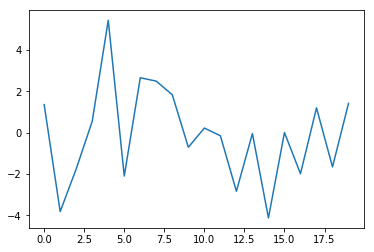

In [11]:
plt.plot(loss_to_print)
plt.show()